# doppler_processing_v001
doppler加工

In [1]:
# import library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from tqdm.notebook import tqdm
import pathlib
import plotly
import plotly.express as px
import itertools
import lightgbm as lgb
from optuna.integration import lightgbm as optuna_lgb
import simdkalman
import optuna
import pyproj
from pyproj import Proj, transform
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, accuracy_score
pd.set_option('display.max_rows', 100)

In [2]:
import ipynb_path

def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [3]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/prep/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

# utils

In [4]:
def get_train_score(df, gt):
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    df = df.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95])
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

In [5]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [6]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)

In [7]:
# ground_truth
def get_ground_truth():
    p = pathlib.Path(INPUT)
    gt_files = list(p.glob('train/*/*/ground_truth.csv'))

    gts = []
    for gt_file in gt_files:
        gts.append(pd.read_csv(gt_file))
    ground_truth = pd.concat(gts)

    return ground_truth

In [8]:
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

In [9]:
class train_result:
    def __init__(self, df):
        self.df = df
        self.gt = get_ground_truth()
        self.bl = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
        
        self.gt = self.gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
        self.df = self.df.merge(self.gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
        self.df['phone'] = self.df['collectionName'] + '_' + self.df['phoneName']
        self.df['err'] =  calc_haversine(self.df['latDeg_gt'], self.df['lngDeg_gt'], self.df['latDeg'], self.df['lngDeg'])
        
        self.phone_res = self.calc_err('phone')
        self.clc_res = self.calc_err('collectionName')
        self.phonename_res = self.calc_err('phoneName')
        
    def calc_err(self, by):
        res = self.df.groupby(by)['err'].agg([percentile50, percentile95])
        res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2
        return res
    
    @property
    def score(self):
        return self.phone_res['p50_p90_mean'].mean()
    @property
    def raw_data(self):
        return self.df
    @property
    def err(self):
        return self.phone_res
    @property
    def collection_err(self):
        return self.clc_res
    @property
    def phonename_err(self):
        return self.phonename_res
    
    def viz_map(self, collection, show_gt=True, show_bl=True):
        tmp = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp2 = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg_gt', 'lngDeg_gt']]
        tmp2 = tmp2.rename(columns={'latDeg_gt':'latDeg', 'lngDeg_gt':'lngDeg'})
        tmp2['phoneName'] = tmp2['phoneName'] + '_GT'
        tmp3 = self.bl[self.bl['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp3['phoneName'] = tmp3['phoneName'] + '_BL'
        
        if show_gt:
            tmp = tmp.append(tmp2)
        if show_bl:
            tmp = tmp.append(tmp3)
        visualize_collection(tmp, collection)

In [10]:
def get_data():
    base_train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
    base_test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
    sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')
    ground_truth = get_ground_truth()
    return base_train, base_test, sample_sub, ground_truth

In [11]:
train, test, sub, gt = get_data()
gt['phone'] = gt['collectionName'] + '_' + gt['phoneName']

In [12]:
dop_train = pd.read_csv('../output/prep/doppler_v001/result_train.csv')
dop_test = pd.read_csv('../output/prep/doppler_v001/result_test.csv')

In [13]:
dop_train = dop_train.sort_values(['phone', 'millisSinceGpsEpoch'])
dop_test = dop_test.sort_values(['phone', 'millisSinceGpsEpoch'])

In [14]:
dop_train['d'] = np.sqrt(dop_train['xVehVel']**2 + dop_train['yVehVel']**2 + dop_train['zVehVel']**2)
dop_test['d'] = np.sqrt(dop_test['xVehVel']**2 + dop_test['yVehVel']**2 + dop_test['zVehVel']**2)

# speed変化量が大きすぎるデータを除外

In [15]:
th=5

In [16]:
dop_train['d_diff_prev'] = abs(dop_train['d'] - dop_train.groupby('phone')['d'].shift(1))
dop_test['d_diff_prev'] = abs(dop_test['d'] - dop_test.groupby('phone')['d'].shift(1))
dop_train['d_diff_next'] = abs(dop_train['d'] - dop_train.groupby('phone')['d'].shift(-1))
dop_test['d_diff_next'] = abs(dop_test['d'] - dop_test.groupby('phone')['d'].shift(-1))

In [17]:
dop_train.loc[(dop_train['d_diff_prev']>th)&(dop_train['d_diff_next']>th), ['xVehVel', 'yVehVel', 'zVehVel', 'd']] = np.nan 
dop_test.loc[(dop_test['d_diff_prev']>th)&(dop_test['d_diff_next']>th), ['xVehVel', 'yVehVel', 'zVehVel', 'd']] = np.nan 

# speedが大きすぎるデータを除外

In [18]:
dop_train.loc[dop_train['d']>50, ['xVehVel', 'yVehVel', 'zVehVel', 'd']] = np.nan 
dop_test.loc[dop_test['d']>50, ['xVehVel', 'yVehVel', 'zVehVel', 'd']] = np.nan 

In [19]:
os.makedirs(f'{OUTPUT}/train/ro', exist_ok=True)

In [20]:
for phone in gt['phone'].unique():
    gt_tmp = gt[gt['phone']==phone].copy()
    dop_tmp = dop_train[dop_train['phone']==phone].copy()
    
    fig, axes = plt.subplots(figsize=(40, 15), nrows=3, sharex=True)
    axes[0].plot(gt_tmp['millisSinceGpsEpoch'], gt_tmp['speedMps'], label='speed')
    axes[0].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['d'], label='d')
    axes[0].legend(loc='upper right')
    axes[0].grid(color='g', linestyle=':', linewidth=0.3)
    
    axes[1].plot(gt_tmp['millisSinceGpsEpoch'], gt_tmp['courseDegree'], label='deg')
    axes[1].legend(loc='upper right')
    axes[1].grid(color='g', linestyle=':', linewidth=0.3)
    
    axes[2].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['xVehVel'], label='xVel')
    axes[2].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['yVehVel'], label='yVel')
    axes[2].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['zVehVel'], label='zVel')
    axes[2].legend(loc='upper right')
    axes[2].grid(color='g', linestyle=':', linewidth=0.3)
    fig.suptitle(phone, fontsize=16)
    fig.savefig(f'{OUTPUT}/train/ro/{phone}.png')
    plt.close()

In [21]:
os.makedirs(f'{OUTPUT}/test/ro', exist_ok=True)

In [22]:
for phone in dop_test['phone'].unique():
    dop_tmp = dop_test[dop_test['phone']==phone].copy()
    
    fig, axes = plt.subplots(figsize=(40, 10), nrows=2, sharex=True)
    axes[0].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['d'], label='d')
    axes[0].legend(loc='upper right')
    axes[0].grid(color='g', linestyle=':', linewidth=0.3)
        
    axes[1].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['xVehVel'], label='xVel')
    axes[1].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['yVehVel'], label='yVel')
    axes[1].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['zVehVel'], label='zVel')
    axes[1].legend(loc='upper right')
    axes[1].grid(color='g', linestyle=':', linewidth=0.3)
    fig.suptitle(phone, fontsize=16)
    fig.savefig(f'{OUTPUT}/test/ro/{phone}.png')
    plt.close()

# 相対座標算出

In [23]:
def WGS84_to_ECEF(lat, lon, alt):
    # convert to radians
    rad_lat = lat * (np.pi / 180.0)
    rad_lon = lon * (np.pi / 180.0)
    a    = 6378137.0
    # f is the flattening factor
    finv = 298.257223563
    f = 1 / finv   
    # e is the eccentricity
    e2 = 1 - (1 - f) * (1 - f)    
    # N is the radius of curvature in the prime vertical
    N = a / np.sqrt(1 - e2 * np.sin(rad_lat) * np.sin(rad_lat))
    x = (N + alt) * np.cos(rad_lat) * np.cos(rad_lon)
    y = (N + alt) * np.cos(rad_lat) * np.sin(rad_lon)
    z = (N * (1 - e2) + alt)        * np.sin(rad_lat)
    return x, y, z

transformer = pyproj.Transformer.from_crs(
    {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'},
    {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'},)

def ECEF_to_WGS84(x,y,z):
    lon, lat, alt = transformer.transform(x,y,z,radians=False)
    return lon, lat, alt

<AxesSubplot:>

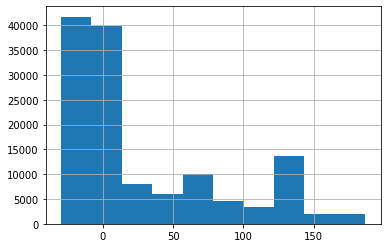

In [24]:
(gt['heightAboveWgs84EllipsoidM'] - 61).hist()

In [25]:
dop_train = dop_train.merge(train[['millisSinceGpsEpoch', 'phone', 'latDeg', 'lngDeg']], on=['millisSinceGpsEpoch', 'phone'], how='left')
dop_test = dop_test.merge(test[['millisSinceGpsEpoch', 'phone', 'latDeg', 'lngDeg']], on=['millisSinceGpsEpoch', 'phone'], how='left')

In [26]:
dop_train['h'] = 0
dop_test['h'] = 0

In [27]:
def calc_rel(df):
    df['x'], df['y'], df['z'] = zip(*df.apply(lambda x: WGS84_to_ECEF(x.latDeg, x.lngDeg, x.h), axis=1))
    df['x_add'] = df['x'] + df['xVehVel']
    df['y_add'] = df['y'] + df['yVehVel']
    df['z_add'] = df['z'] + df['zVehVel']
    df['lng_add'], df['lat_add'], df['h_add'] = zip(*df.apply(lambda x: ECEF_to_WGS84(x.x_add, x.y_add, x.z_add), axis=1))
    df['lat_rel'] = df['lat_add'] - df['latDeg']
    df['lng_rel'] = df['lng_add'] - df['lngDeg']   
    return df

In [28]:
dop_train = calc_rel(dop_train)
dop_test = calc_rel(dop_test)

In [29]:
dop_train.to_csv(OUTPUT+'/train_result.csv', index=False)
dop_test.to_csv(OUTPUT+'/test_result.csv', index=False)

# 確認

In [30]:
os.makedirs(f'{OUTPUT}/train/rel', exist_ok=True)

In [31]:
for phone in dop_train['phone'].unique():
    gt_tmp = gt[gt['phone']==phone].copy()
    gt_tmp['lat_diff_gt'] = gt_tmp['latDeg'].shift(-1) - gt_tmp['latDeg']
    gt_tmp['lng_diff_gt'] = gt_tmp['lngDeg'].shift(-1) - gt_tmp['lngDeg']
    
    dop_tmp = dop_train[dop_train['phone']==phone].copy()
    
    fig, axes = plt.subplots(figsize=(40, 15), nrows=2, sharex=True)
    axes[0].plot(gt_tmp['millisSinceGpsEpoch'], gt_tmp['lat_diff_gt'], label='lat_diff_gt')
    axes[0].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['lat_rel'], label='lat_rel')
    axes[0].legend(loc='upper right')
    axes[0].grid(color='g', linestyle=':', linewidth=0.3)
    
    axes[1].plot(gt_tmp['millisSinceGpsEpoch'], gt_tmp['lng_diff_gt'], label='lng_diff_gt')
    axes[1].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['lng_rel'], label='lng_rel')
    axes[1].legend(loc='upper right')
    axes[1].grid(color='g', linestyle=':', linewidth=0.3)
    
    fig.suptitle(phone, fontsize=16)
    fig.savefig(f'{OUTPUT}/train/rel/{phone}.png')
    plt.close()

In [32]:
os.makedirs(f'{OUTPUT}/test/rel', exist_ok=True)

In [33]:
for phone in dop_test['phone'].unique():
    gt_tmp = gt[gt['phone']==phone].copy()
    gt_tmp['lat_diff_gt'] = gt_tmp['latDeg'].shift(-1) - gt_tmp['latDeg']
    gt_tmp['lng_diff_gt'] = gt_tmp['lngDeg'].shift(-1) - gt_tmp['lngDeg']
    
    dop_tmp = dop_test[dop_test['phone']==phone].copy()
    
    fig, axes = plt.subplots(figsize=(40, 15), nrows=2, sharex=True)
    axes[0].plot(gt_tmp['millisSinceGpsEpoch'], gt_tmp['lat_diff_gt'], label='lat_diff_gt')
    axes[0].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['lat_rel'], label='lat_rel')
    axes[0].legend(loc='upper right')
    axes[0].grid(color='g', linestyle=':', linewidth=0.3)
    
    axes[1].plot(gt_tmp['millisSinceGpsEpoch'], gt_tmp['lng_diff_gt'], label='lng_diff_gt')
    axes[1].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['lng_rel'], label='lng_rel')
    axes[1].legend(loc='upper right')
    axes[1].grid(color='g', linestyle=':', linewidth=0.3)
    
    fig.suptitle(phone, fontsize=16)
    fig.savefig(f'{OUTPUT}/test/rel/{phone}.png')
    plt.close()